In [747]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm  
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [748]:
bike = pd.read_csv('day.csv')
bike.head() 

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [749]:
bikeset=bike

In [750]:
bikeset['season'] =  bikeset['season'].apply(lambda x: 'spring' if x==1 else 'summer'  if x==2 else 'fall' if x==3 else 'winter')
bikeset.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [751]:
#Converting categorial variables to individual variables, dropping first value ( fall)
status = pd.get_dummies(bikeset['season'], drop_first = True)
bikeset = pd.concat([bikeset, status], axis = 1)
bikeset=bikeset.drop(['season'], axis=1)
bikeset.head()

,instant,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,1,01-01-2018,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,2,02-01-2018,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,3,03-01-2018,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,4,04-01-2018,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,5,05-01-2018,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [752]:
bikeset.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [753]:
#Converting categorial variable weatahersit to individual variables,
bikeset['clear'] =  bikeset['weathersit'].apply(lambda x: 1 if x==1  else 0)
bikeset['mist'] =  bikeset['weathersit'].apply(lambda x: 1 if x==2  else 0)
#If all zero, assume light now
bikeset.columns

Index(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'spring', 'summer', 'winter', 'clear', 'mist'],
      dtype='object')

In [754]:
#Rename field to be more descriptive
bikeset['yr_2019']=bikeset['yr']
bikeset=bikeset.drop(['yr' ], axis=1)

In [755]:
#Grouping months into quarters
bikeset['First_Quarter'] =  bikeset['mnth'].apply(lambda x: 1 if x==1 or x == 2 or x ==3  else 0)
bikeset['Second_Quarter'] =  bikeset['mnth'].apply(lambda x: 1 if x==4 or x == 5 or x ==6 else 0)
bikeset['Third_Quarter'] =  bikeset['mnth'].apply(lambda x: 1 if x==7 or x == 8 or x ==9 else 0)
#All zeroes assume fourth quarter 

In [756]:
#Grouping weekdays into weekdays and weekends. If Day056 is 0, assume Day1234
bikeset['Day056'] =  bikeset['weekday'].apply(lambda x: 1 if x == 5 or x ==6 else 0)


In [757]:
#atemp and temp care closely dependent so removing one of them. Removing other variables which are not driving cnt
bikeset=bikeset.drop(['weekday','mnth','instant','temp','dteday','weathersit','registered',
                      'casual','workingday' ], axis=1)

In [758]:
sns.pairplot(bikeset)
plt.show()


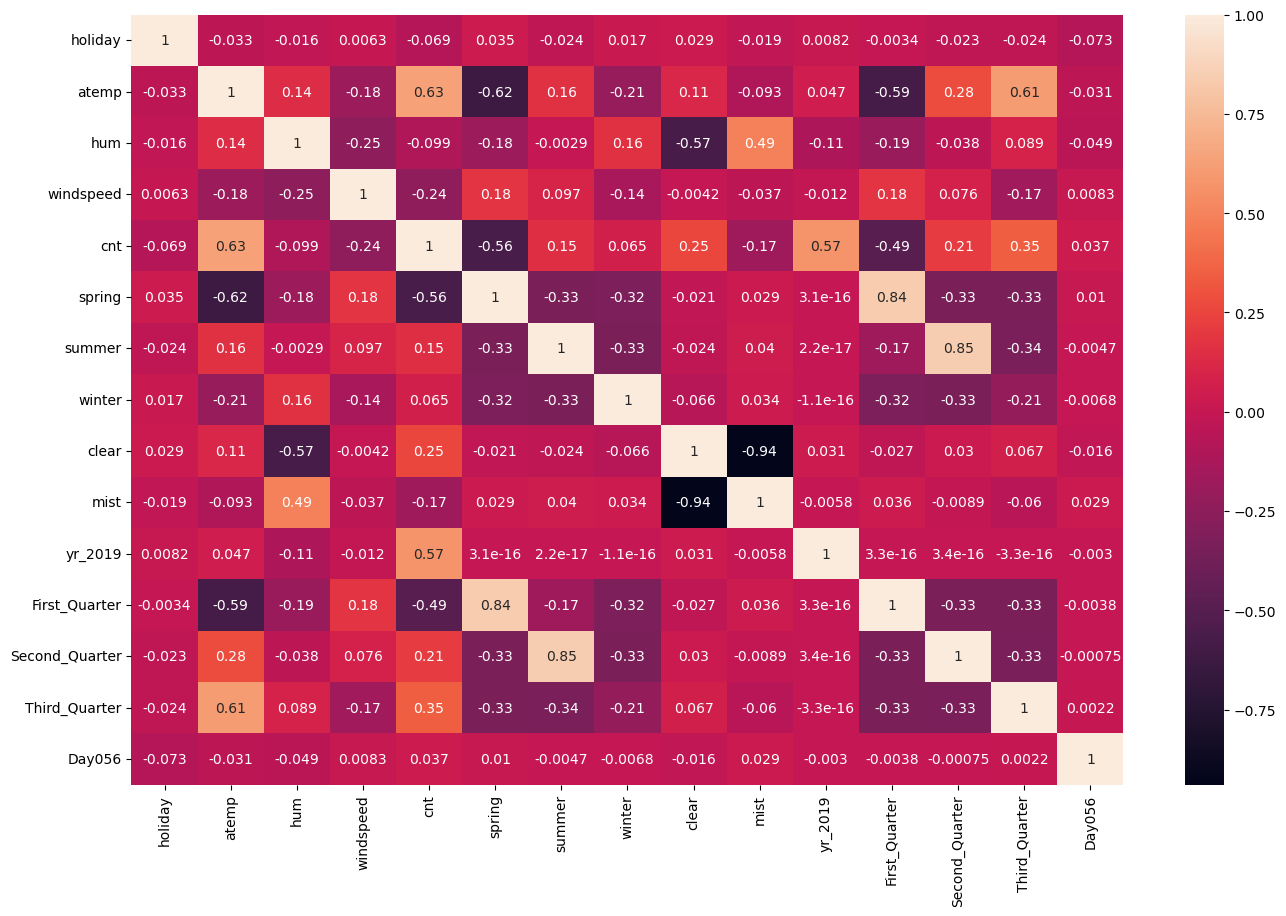

In [781]:
plt.figure (figsize = (16,10))
sns.heatmap(bikeset.corr(), annot=True)
plt.show()
# We see that cnt has high correlation with atemp, yr_2019 and third quarter

### Build Model

In [760]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bikeset, train_size = 0.7, test_size = 0.3, random_state = 100)

In [761]:
print ( df_train.shape, df_test.shape)

(510, 15) (219, 15)


In [762]:
y_train = df_train.pop('cnt')
X_train = df_train

In [763]:
lmr=LinearRegression()
lmr.fit(X_train,y_train)
rfe = RFE (lmr,n_features_to_select=10)
rfe=rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('atemp', False, 3),
 ('hum', False, 5),
 ('windspeed', False, 4),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('clear', True, 1),
 ('mist', True, 1),
 ('yr_2019', True, 1),
 ('First_Quarter', True, 1),
 ('Second_Quarter', True, 1),
 ('Third_Quarter', True, 1),
 ('Day056', False, 2)]

In [764]:
col = X_train.columns[rfe.support_]
col

Index(['holiday', 'spring', 'summer', 'winter', 'clear', 'mist', 'yr_2019',
       'First_Quarter', 'Second_Quarter', 'Third_Quarter'],
      dtype='object')

In [765]:
X_train_rfe = X_train[col]

In [766]:
# Adding a constant variable 
X_train_rfe_sm = sm.add_constant(X_train_rfe)

In [767]:
lm = sm.OLS(y_train,X_train_rfe_sm).fit()   # Running the linear model

In [768]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     157.1
Date:                Sat, 28 Oct 2023   Prob (F-statistic):          3.84e-147
Time:                        21:59:49   Log-Likelihood:                -4224.5
No. Observations:                 510   AIC:                             8471.
Df Residuals:                     499   BIC:                             8518.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            719.8698    365.380      1.

In [769]:
vif=pd.DataFrame()
vif['Features']=X_train_rfe.columns
vif['VIF']=[variance_inflation_factor(X_train_rfe.values,i) for i in range (X_train_rfe.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
4,clear,13.32
1,spring,8.45
8,Second_Quarter,8.25
5,mist,7.90
7,First_Quarter,7.51
2,summer,7.08
9,Third_Quarter,5.42
3,winter,4.93
6,yr_2019,2.05
0,holiday,1.04


In [770]:
X_train_new = X_train_rfe.drop(["First_Quarter","summer","mist" ], axis = 1)

In [771]:
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     197.9
Date:                Sat, 28 Oct 2023   Prob (F-statistic):          6.32e-140
Time:                        21:59:50   Log-Likelihood:                -4249.6
No. Observations:                 510   AIC:                             8515.
Df Residuals:                     502   BIC:                             8549.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2348.6661    209.884     11.

In [772]:
vif=pd.DataFrame()
vif['Features']=X_train_new.columns
vif['VIF']=[variance_inflation_factor(X_train_new.values,i) for i in range (X_train_new.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,clear,2.56
4,yr_2019,1.97
5,Second_Quarter,1.63
6,Third_Quarter,1.61
1,spring,1.57
2,winter,1.46
0,holiday,1.04


### Residual analysis

In [773]:
y_train_count = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

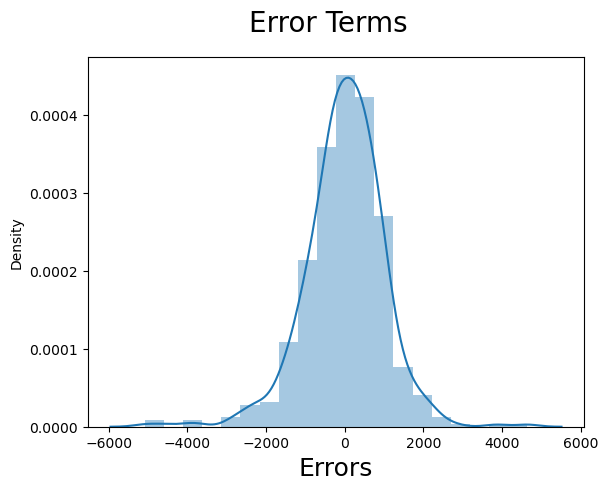

In [774]:
fig = plt.figure()
sns.distplot((y_train - y_train_count), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)      
#Residual errors have a mean value of zero.  

### making predictions

In [775]:

y_test = df_test.pop('cnt')
X_test = df_test

In [776]:
#X_train_new = X_train_new.drop(["const" ], axis = 1)
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [777]:
# Making predictions
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

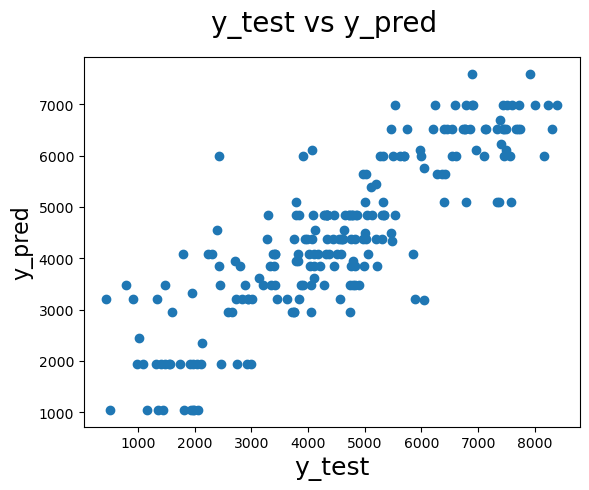

In [778]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label


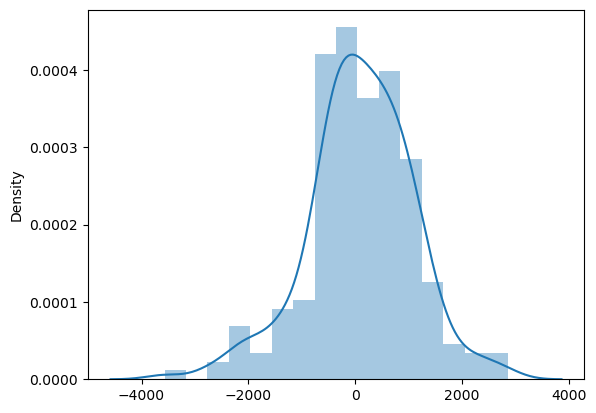

In [779]:
res = y_test - y_pred
sns.distplot(res)
plt.show()


In [780]:
r2_score(y_true=y_test, y_pred=y_pred)

0.7256872637820106